# Predicting defaulting on credit card applications 

When customers come in financial difficulties, it usually does not happen at once. There are indicators which can be used to anticipate the final outcome, such as late payments, calls to the customer services, enquiries about the products, a different browsing pattern on the web or mobile app. By using such patterns it is possible to prevent, or at least guide the process and provide a better service for the customer as well as reduced risks for the bank.

In this tutorial we will look at how to predict defaulting, using statistics, machine learning and deep learning. We we also look at how to summarize the data using topological data analysis (TDA). Finally we will look at how to APIfy the model and use it for account alerting.

#### Imports

In [66]:

#data explore
import numpy as np

# dataframes in python
import pandas as pd

In [67]:
%matplotlib inline
import matplotlib.pyplot as plt

#defaults
plt.rcParams['figure.figsize'] = (20.0, 20.0)
plt.rcParams.update({'font.size': 10})
plt.rcParams['xtick.major.pad']='5'
plt.rcParams['ytick.major.pad']='5'

plt.style.use('ggplot')

#### Data preparation
I read the data from the raw csv which is the competition dataset
* ignoring the missing data fillna(0)
* ignoring the imbalanled sample
* train model after normalization

In [118]:

# coding: utf-8


# #### Data preparation
# We cache the data set from the above mentioned repository in a local directory. 

#verify_sample=pd.read_csv("./verify_sample.csv")
model_sample = pd.read_csv("./model_sample.csv")
#test_result = verify_sample.iloc[:,[0,1]]
#verify_sample = verify_sample.drop('y', axis=1)


# #### Convert the data
# We use pandas to read the data from its original excel format into a dataframe

# In[5]:

df = model_sample
df = df.fillna(0)
#verify_sample = verify_sample.fillna(0)


# #### Clean up
# We lowercase the column name, and rename the column names when required,
# In particular, remarkably this dataset misses a colum `PAY_1`. In the analysis here below we assume that PAY_0 is actually pay_1, to be consider the repayment of the month prior to the month where we calculate the defaulting (which is October 2005, in this particular dataset)

df = df.drop('user_id', axis=1)

# ### Feature engineering
# 
# It's not about blind feature conversion to values between 0 and 1, it's about understanding data. In this case we see that money they exibits a log/log distribution, so first off, we are going to take the log of the money.


# help func
# select those need log
def selcols():
    colnames = []
    colnames.extend(['x_041','x_043','x_044','x_045','x_046','x_047'])
    colnames.extend(['x_052','x_053','x_054','x_055','x_057','x_058','x_059'])
    colnames.extend(['x_060','x_061','x_064','x_067'])
    colnames.extend(['x_070','x_073','x_078','x_079'])
    colnames.extend(['x_080','x_085','x_086','x_087'])
    colnames.extend(['x_108','x_111','x_114','x_117','x_120','x_125','x_126','x_127'])
    colnames.extend(['x_130','x_131','x_133','x_135','x_136','x_138'])
    colnames.extend(['x_140','x_141','x_143','x_145','x_146','x_147','x_148'])
    colnames.extend(['x_159','x_160','x_161','x_172','x_173','x_174'])
    colnames.extend(['x_185','x_186','x_187'])
    return colnames

# generate the new dataset by log
colindex = selcols()
for col in colindex:
    df[col] = df[col].apply(lambda x: np.log(x+1) if x>0 else 0) 
    #verify_sample[col] = verify_sample[col].apply(lambda x: np.log(x+1) if x>0 else 0)


# ### Seperate the labels and input variables


y = df.iloc[:, 0]
X = df.iloc[:,1:]
#verify_X = verify_sample.iloc[:,1:]


# #### Feature scaling

# three diffrent methods
#- MinMaxScaler
#- StandardScaler N(0,1)
#- RobustScaler avoid outliers.

#- X_test's standardization should use the mean and std of X_train

def MinMaxNorm(X_train,X_test):
    from sklearn.preprocessing import MinMaxScaler

    mms = MinMaxScaler().fit(X_train)
    X_train_norm = mms.transform(X_train)
    X_test_norm = mms.transform(X_test)
    return X_train_norm,X_test_norm

def StdNorm(X_train,X_test):
    from sklearn.preprocessing import StandardScaler

    stdsc = StandardScaler().fit(X_train)
    X_train_std = stdsc.transform(X_train)
    X_test_std = stdsc.transform(X_test)
    return X_train_std,X_test_std

def RobustNorm(X_train,X_test):
    from sklearn.preprocessing import RobustScaler

    rbs = RobustScaler().fit(X_train)
    X_train_std = rbs.transform(X_train)
    X_test_std = rbs.transform(X_test)
    return X_train_std,X_test_std



#X_prep = RobustNorm(X)


# here you should notice that the X_test's standardization should use the train data's method
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test = RobustNorm(X_train, X_test)

# Feture Selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score, log_loss, f1_score

feat_labels = df.columns[1:]

forest = RandomForestClassifier(n_estimators=500, min_samples_split=5,min_samples_leaf =2,
                                max_features = 'log2',n_jobs=4,criterion='gini')

forest.fit(X_train, y_train)
importances = forest.feature_importances_

indices = np.argsort(importances)[100:]

X_train = X_train[:,indices]
X_test = X_test[:,indices]

#y_train = y_train.reshape(8813,1)
y_train = y_train.values
y_test = y_test.values

#y_train_len = y_train.shape[0]
#y_train = y_train.reshape(y_train_len,1)
#y_test_len = y_test.shape[0]
#y_test = y_test.reshape(y_test_len,1)
'''
threshold = best_f1_threshold
verify_y_test_pred = rf.predict_proba(verify_X_test_prep)[:,1]
user_id = verify_sample.loc[:,['user_id']]
y_prediction  = (verify_y_test_pred > threshold).astype(int)
predict_result = pd.DataFrame(y_prediction,columns=['y_prediction'])
predict_result = user_id.join(predict_result)
p_y = predict_result['y_prediction'].values
real_y = test_result['y'].values


# In[34]:

# 预测结果的f1值
score = f1_score(real_y, p_y)

print score

'''


"\nthreshold = best_f1_threshold\nverify_y_test_pred = rf.predict_proba(verify_X_test_prep)[:,1]\nuser_id = verify_sample.loc[:,['user_id']]\ny_prediction  = (verify_y_test_pred > threshold).astype(int)\npredict_result = pd.DataFrame(y_prediction,columns=['y_prediction'])\npredict_result = user_id.join(predict_result)\np_y = predict_result['y_prediction'].values\nreal_y = test_result['y'].values\n\n\n# In[34]:\n\n# 预测结果的f1值\nscore = f1_score(real_y, p_y)\n\nprint score\n\n"

## Models
* Logistic regression
* SVM
* RandomForest
    * RandomForestClassifier
    * GradientBoostingClassifier
* Deep Neural Network

### Model valuation
* Visualization: Confusion matrices and AUC curves
* f1 score

In [69]:
import itertools
from sklearn.metrics import roc_curve, auc, roc_auc_score, log_loss, accuracy_score, confusion_matrix,f1_score

def plot_cm(ax, y_true, y_pred, classes, title, th=0.5, cmap=plt.cm.Blues):
    y_pred_labels = (y_pred>th).astype(int)
    
    cm = confusion_matrix(y_true, y_pred_labels)
    
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)

    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')

def plot_auc(ax, y_train, y_train_pred, y_test, y_test_pred, th=0.5):

    y_train_pred_labels = (y_train_pred>th).astype(int)
    y_test_pred_labels  = (y_test_pred>th).astype(int)

    fpr_train, tpr_train, _ = roc_curve(y_train,y_train_pred)
    roc_auc_train = auc(fpr_train, tpr_train)
    acc_train = accuracy_score(y_train, y_train_pred_labels)

    fpr_test, tpr_test, _ = roc_curve(y_test,y_test_pred)
    roc_auc_test = auc(fpr_test, tpr_test)
    acc_test = accuracy_score(y_test, y_test_pred_labels)

    ax.plot(fpr_train, tpr_train)
    ax.plot(fpr_test, tpr_test)

    ax.plot([0, 1], [0, 1], 'k--')

    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC curve')
    
    train_text = 'train acc = {:.3f}, auc = {:.2f}'.format(acc_train, roc_auc_train)
    test_text = 'test acc = {:.3f}, auc = {:.2f}'.format(acc_test, roc_auc_test)
    ax.legend([train_text, test_text])
def result_analyse(est,threshold,X_train,X_test,y_train,y_test):
    y_train_pred = est.predict_proba(X_train)[:,-1]
    y_test_pred = est.predict_proba(X_test)[:,-1]


    fig,ax = plt.subplots(1,3)
    fig.set_size_inches(15,5)

    plot_cm(ax[0],  y_train, y_train_pred, [0,1], 'Confusion matrix (TRAIN)', threshold)
    plot_cm(ax[1],  y_test, y_test_pred,   [0,1], 'Confusion matrix (TEST)', threshold)
    plot_auc(ax[2], y_train, y_train_pred, y_test, y_test_pred, threshold)
    
    plt.tight_layout()
    plt.show()



### F1 score 
* this value is required by the competition, teams are ranked by F1 score
* F1 score is sensitive to the threshold of probability, so, here I define a function to select relative best threshold to serve as the threshold test data
    *  I will select the average threshold which 5 continue f1 score is maximum

In [70]:
from sklearn.metrics import accuracy_score,f1_score
#est learning estimator
def best_threshold_f1_score(est,X_test,y_test):
    thresholds = np.linspace(0.3,0.6,100)
    y_test_pred = est.predict_proba(X_test)[:,-1]
    score_set = []
    index_threshold = 0
    sum_score = 0
    for threshold in thresholds:
        y_test_pred1  = (y_test_pred > threshold).astype(int)
        score = f1_score(y_test, y_test_pred1)
        score_set.append(score)
    for i in range(95):
        temp = sum(score_set[i:i+5])
        if temp > sum_score:
            sum_score = temp
            index_threshold = i+2 # the average threshold
    
    return thresholds[index_threshold],sum_score/5

def test_f1_score(est,best_threshold,X_test,y_test):
    y_test_pred = est.predict_proba(X_test)[:,-1]
    y_test_pred1  = (y_test_pred > best_threshold).astype(int)
    score = f1_score(y_test, y_test_pred1)
    return score

    

In [76]:
class_weights = dict(zip([0, 1], compute_class_weight('balanced', [0, 1], y_train)))
class_weights

{0: 0.6224749258369826, 1: 2.5412341407151096}

#### Logistic regression

In [77]:
from sklearn.linear_model import LogisticRegression
# Create logistic regression object
regr = LogisticRegression(penalty='l2', C=10.**2, random_state=0,class_weight = class_weights)

# Train the model using the training sets
regr.fit(X_train, y_train)

LogisticRegression(C=100.0,
          class_weight={0: 0.6224749258369826, 1: 2.5412341407151096},
          dual=False, fit_intercept=True, intercept_scaling=1,
          max_iter=100, multi_class='ovr', n_jobs=1, penalty='l2',
          random_state=0, solver='liblinear', tol=0.0001, verbose=0,
          warm_start=False)

#### Result Analyse
* train and test f1 score
* train and test confusion matrix
* ROC curve

test f1 score: 0.4854700854700854 train f1 score: 0.5116187589604542


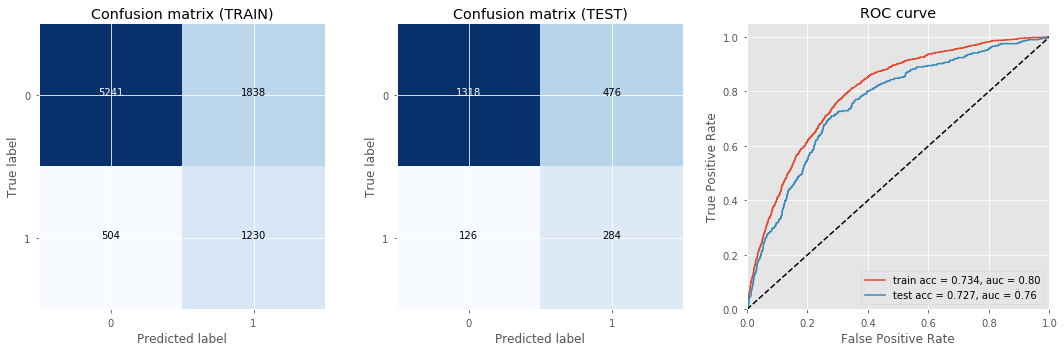

In [78]:
best_threshold,best_f1_score = best_threshold_f1_score(regr,X_train,y_train)
test_f1 = test_f1_score(regr,best_threshold,X_test,y_test)
print('test f1 score:',test_f1,'train f1 score:',best_f1_score)
result_analyse(regr,best_threshold,X_train,X_test,y_train,y_test)

### SVM

In [79]:
from sklearn import svm
sm = svm.SVC(kernel='rbf', C=0.1,probability=True,class_weight = class_weights)
sm.fit(X_train,y_train)

SVC(C=0.1, cache_size=200,
  class_weight={0: 0.6224749258369826, 1: 2.5412341407151096}, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

test f1 score: 0.0 train f1 score: 0.6219028743439


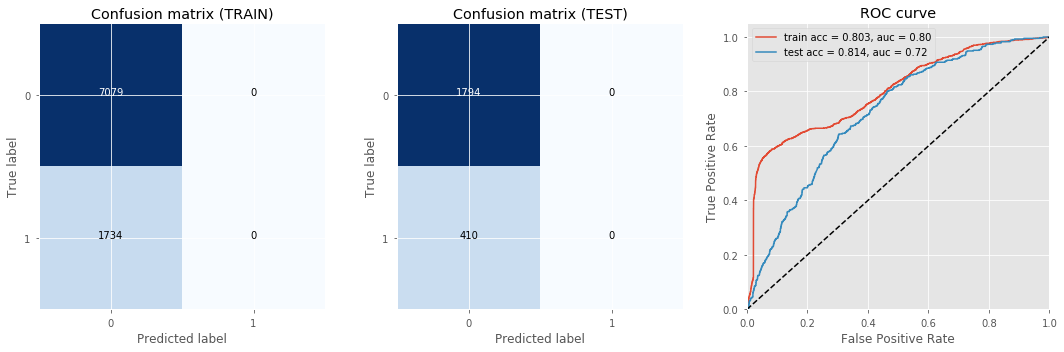

In [81]:
best_threshold,best_f1_score = best_threshold_f1_score(sm,X_train,y_train)
test_f1 = test_f1_score(sm,best_threshold,X_test,y_test)
print('test f1 score:',test_f1,'train f1 score:',best_f1_score)
result_analyse(sm,best_threshold,X_train,X_test,y_train,y_test)

#### Random Forest 
bootstrap aggregating ensamble of decision trees

In [123]:
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings("ignore")
rf = RandomForestClassifier(n_estimators=500,max_depth = 8, min_samples_split=5,min_samples_leaf =2,max_features = 'sqrt',class_weight = class_weights,n_jobs=4,criterion='gini')
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True,
            class_weight={0: 0.6224749258369826, 1: 2.5412341407151096},
            criterion='gini', max_depth=8, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=2,
            min_samples_split=5, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=4, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

test f1 score: 0.4758909853249476 train f1 score: 0.6454466384020996


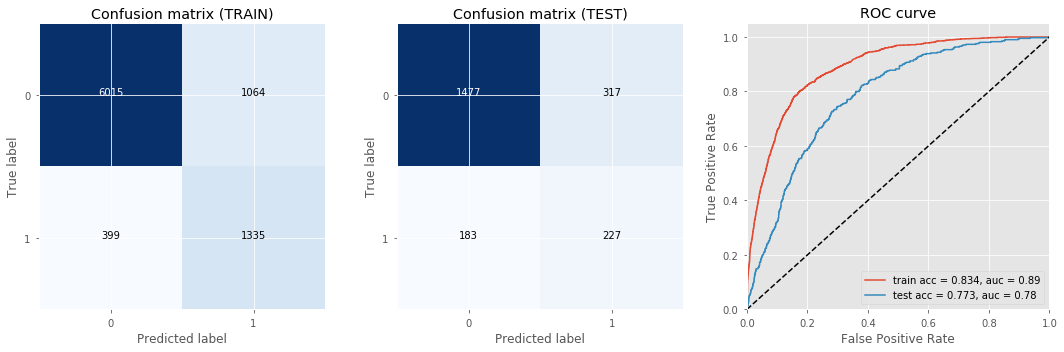

In [124]:
best_threshold,best_f1_score = best_threshold_f1_score(rf,X_train,y_train)
test_f1 = test_f1_score(rf,best_threshold,X_test,y_test)
print('test f1 score:',test_f1,'train f1 score:',best_f1_score)
result_analyse(rf,best_threshold,X_train,X_test,y_train,y_test)

### GradientBoostingClassifier

In [125]:

from sklearn.ensemble import GradientBoostingClassifier
gbdt=GradientBoostingClassifier(
  loss='deviance'
, learning_rate=0.1
, n_estimators=500
, subsample=1
, min_samples_split=2
, min_samples_leaf=1
, max_depth=2
, init=None
, random_state=None
, max_features='log2'
, verbose=0
, max_leaf_nodes=None
, warm_start=False)

gbdt.fit(X_train,y_train)



GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=2,
              max_features='log2', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              presort='auto', random_state=None, subsample=1, verbose=0,
              warm_start=False)

test f1 score: 0.4591947769314472 train f1 score: 0.5888300065564815


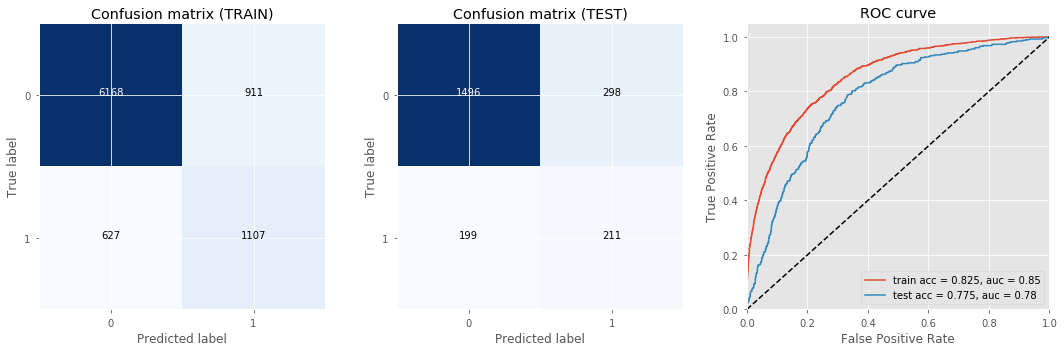

In [126]:
best_threshold,best_f1_score = best_threshold_f1_score(gbdt,X_train,y_train)
test_f1 = test_f1_score(gbdt,best_threshold,X_test,y_test)
print('test f1 score:',test_f1,'train f1 score:',best_f1_score)
result_analyse(gbdt,best_threshold,X_train,X_test,y_train,y_test)

### Deep Neural Network

In [23]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 381566781921934953
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 116858880
locality {
  bus_id: 1
}
incarnation: 17588410628103198217
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0"
]


In [115]:
import warnings
warnings.filterwarnings("ignore")

In [130]:
from __future__ import print_function
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout

from keras.callbacks import BaseLogger, EarlyStopping, ReduceLROnPlateau, TensorBoard
from sklearn.preprocessing import StandardScaler
from sklearn.utils import compute_class_weight
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_curve,f1_score
import os

# Reproducible random seed
seed = 1

# Create the output directories, if they don't exist
try:
    os.makedirs("logs")
except OSError:
    if not os.path.isdir("logs"):
        raise

try:
    os.makedirs("figs")
except OSError:
    if not os.path.isdir("figs"):
        raise


X = X_train
Y = y_train
# Estimate class weights since the dataset is unbalanced
class_weights = dict(zip([0, 1], compute_class_weight('balanced', [0, 1], Y)))



# Create train/test indices to split data in train/test sets
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)


# Define a model generator
def generate_model():
    _model = Sequential()
    _model.add(Dropout(0.2,input_shape=(X.shape[1],)))
    _model.add(Dense(128, kernel_initializer='random_uniform',activation='relu'))
    _model.add(Dropout(0.4))
    #_model.add(Dense(50,activation='relu'))
    _model.add(Dense(32,kernel_initializer='random_uniform',activation='relu'))
    _model.add(Dropout(0.4))
    #_model.add(Dense(25,activation='relu'))
    #_model.add(Dense(15,activation='relu'))
    #_model.add(Dropout(0.2))
    _model.add(Dense(1,kernel_initializer='random_uniform', activation='sigmoid'))
    _model.compile(loss='binary_crossentropy', optimizer='adam')
    return _model


# Storage
k = 0
predictions = np.empty([len(Y), kfold.n_splits])
for train, test in kfold.split(X, Y):
    # Define model
    model = generate_model()
    print('LOOP:',k)
    # Fit the model
    history = model.fit(X[train], Y[train],
                        batch_size=64,
                        epochs=200,
                        verbose=0,
                        shuffle=True,
                        validation_data=(X[test], Y[test]),
                        class_weight=class_weights)
                        #callbacks=[baselogger, earlystop, reduce_lr])
    # Store the predicted probabilities and iterate k
    
    predictions[train, k] = model.predict_proba(X[train]).flatten()
    k += 1

# Average the model predictions
yhat = np.nanmean(predictions, axis=1).round().astype(int)

# Performance
print(classification_report(Y, yhat))
print(pd.crosstab(Y, yhat.flatten(), rownames=['Truth'], colnames=['Predictions']))

'''
fpr, tpr, thresholds = roc_curve(Y, yhat)
precision, recall, thresholds = precision_recall_curve(Y, yhat)
f1 = f1_score(Y, yhat, average=None)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.,1.])
plt.ylim([0.,1.])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#plt.savefig("figs/ROC.png")

plt.clf()
plt.title('Precision Recall Curve')
plt.plot(recall, precision, 'b')
plt.xlim([0.,1.])
plt.ylim([0.,1.])
plt.ylabel('Precision')
plt.xlabel('Recall')
#plt.savefig("figs/precision-recall.png")
'''

LOOP: 0
LOOP: 1
LOOP: 2
LOOP: 3
LOOP: 4
LOOP: 5
LOOP: 6
LOOP: 7
LOOP: 8
LOOP: 9
             precision    recall  f1-score   support

          0       0.95      0.77      0.85      7079
          1       0.48      0.85      0.61      1734

avg / total       0.86      0.79      0.81      8813

Predictions     0     1
Truth                  
0            5476  1603
1             265  1469


'\nfpr, tpr, thresholds = roc_curve(Y, yhat)\nprecision, recall, thresholds = precision_recall_curve(Y, yhat)\nf1 = f1_score(Y, yhat, average=None)\nroc_auc = auc(fpr, tpr)\n\nplt.title(\'Receiver Operating Characteristic\')\nplt.plot(fpr, tpr, \'b\', label=\'AUC = %0.2f\'% roc_auc)\nplt.legend(loc=\'lower right\')\nplt.plot([0,1],[0,1],\'r--\')\nplt.xlim([0.,1.])\nplt.ylim([0.,1.])\nplt.ylabel(\'True Positive Rate\')\nplt.xlabel(\'False Positive Rate\')\n#plt.savefig("figs/ROC.png")\n\nplt.clf()\nplt.title(\'Precision Recall Curve\')\nplt.plot(recall, precision, \'b\')\nplt.xlim([0.,1.])\nplt.ylim([0.,1.])\nplt.ylabel(\'Precision\')\nplt.xlabel(\'Recall\')\n#plt.savefig("figs/precision-recall.png")\n'

test f1 score: 0.4807302231237322 train f1 score: 0.6025846348579635


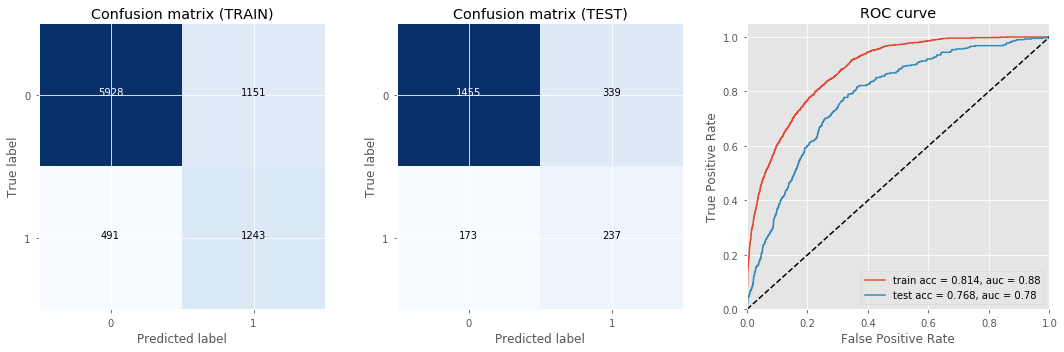

In [131]:
best_threshold,best_f1_score = best_threshold_f1_score(model,X_train,y_train)
test_f1 = test_f1_score(model,best_threshold,X_test,y_test)
print('test f1 score:',test_f1,'train f1 score:',best_f1_score)

result_analyse(model,best_threshold,X_train,X_test,y_train,y_test)